<div class="alert alert-block alert-info">

# 1. Baseline model: bag of words

## Unpack zip files

### Train.zip

In [1]:
from zipfile import ZipFile
with ZipFile('Train.zip', 'r') as zip:
    zip.extractall()

### Test.zip

In [ ]:
from zipfile import ZipFile
with ZipFile('Test.zip', 'r') as zip:
    zip.extractall()

## Loading the train and test data

In [1]:
"""Module for loading the train and test data.

This module supports loading the data in two seperate ways.
The first, which is done by calling the load_train and load_test functions,
opens and parses the text files one by one. Because of the abundance of files,
this can take a while.
The second way of loading the data is by opening a pickle file containing the
results of the load_train and load_test functions. To create this pickle file,
call the create_data_pickle function once. Afterwards, you will be ablo to
quickly load the data using the load_data_pickle function.
"""
import collections
import glob
import os
import re
import warnings

#import utils


## Default data folder names ## 


DEFAULT_DATA_LOCATION = 'Data'
DEFAULT_TRAIN_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Train')
DEFAULT_TEST_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Test')

DEFAULT_PICKLE_PATH = os.path.join(DEFAULT_DATA_LOCATION, 'data.pkl')

PRICE_LOCATION_FILE_NAME = 'hotels.txt'
HOTEL_REVIEWS_FILE_TEMPLATE = 'Hotel_*.txt'
TEST_REVIEWS_FILE_TEMPLATE = '*.txt'


## Classes to store the parsed data in. ##


Hotel = collections.namedtuple(
  'Hotel', ['id', 'price', 'location'])
Review = collections.namedtuple(
  'Review', [
      'id', 'author', 'content', 'date', 'rating', 'subratings', 'hotel'])
Subratings = collections.namedtuple(
  'Subratings', [
      'value', 'rooms', 'location', 'cleanliness',
      'front_desk', 'service', 'business_service'])


## Helper functions for parsing data ##


def _parse_price_location_file(price_location_lines):
  hotels = {}
  for hotel_line in price_location_lines[1:]:
    tokens = hotel_line.strip().split(',')
    hotel_id = int(tokens[0])
    price = int(tokens[1])
    location = tokens[2]
    hotels[hotel_id] = Hotel(id=hotel_id, price=price, location=location)
  return hotels


def _extract_id_from_file_name(review_file_name):
  regex_res = re.findall('\d+', review_file_name)
  assert len(regex_res) == 1
  return int(regex_res[0])


_AUTHOR_TAG = '<Author>'
_CONTENT_TAG = '<Content>'
_DATE_TAG = '<Date>'
_RATING_TAG = '<Overall_rating>'
_SUBRATING_TAG = '<Subratings>'
_PRICE_TAG = '<Price>'
_LOCATION_TAG = '<Location>'


def _parse_string_line(line, tag):
  assert line.startswith(tag)
  return line.strip()[len(tag):]


def _parse_author_line(author_line):
  return _parse_string_line(author_line, _AUTHOR_TAG)


def _parse_content_line(content_line):
  return _parse_string_line(content_line, _CONTENT_TAG)


def _parse_date_line(date_line):
  return _parse_string_line(date_line, _DATE_TAG)


def _parse_rating_line(rating_line):
  rating_string = _parse_string_line(rating_line, _RATING_TAG)
  return int(rating_string)


def _parse_price_line(price_line):
  price_string = _parse_string_line(price_line, _PRICE_TAG)
  return int(price_string)


def _parse_location_line(location_line):
  return _parse_string_line(location_line, _LOCATION_TAG)


def _parse_subratings_line(subratings_line):
  subratings_string = _parse_string_line(subratings_line, _SUBRATING_TAG)
  subrating_tokens = subratings_string.split(',')

  subratings = {}
  for token in subrating_tokens:
    left, right = token.strip().split('=')
    subratings[left] = int(right)

  return Subratings(**subratings)


def _parse_single_hotel_review(review_lines, hotel):
  author_line, content_line, date_line, overall_rating_line, subratings_line = (
      review_lines)
  # Parse each of the lines
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  rating = _parse_rating_line(overall_rating_line)
  subratings = _parse_subratings_line(subratings_line)
  return Review(
      id=-1, author=author, content=content, date=date, rating=rating,
      subratings=subratings, hotel=hotel)


def _parse_hotel_review_file(hotel_review_lines, hotel):
  assert len(hotel_review_lines)%6 == 0
  hotel_reviews = []
  for start_idx in range(0, len(hotel_review_lines), 6):
    review_lines = hotel_review_lines[start_idx:start_idx+5]
    hotel_reviews.append(_parse_single_hotel_review(review_lines, hotel))
  return hotel_reviews


def _parse_test_review_file(test_review_lines, review_id):
  assert len(test_review_lines) == 5
  author_line, content_line, date_line, price_line, location_line = (
      test_review_lines)
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  price = _parse_price_line(price_line)
  location = _parse_location_line(location_line)
  unknown_hotel = Hotel(id=-1, price=price, location=location)
  review = Review(
      id=review_id, author=author, content=content, date=date, rating=-1,
      subratings=None, hotel=unknown_hotel)
  return review


## Functions for loading and parsing all of the data ##


def load_train(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION):
  """Loads and parses the train data.

  Args:
    train_data_folder: string containing the path to the folder containing the
        training data.

  Returns:
    A list of all the reviews. Each review is a namedtuple object containing
    the author, content, date, rating, subratings and hotel data. The hotel
    data is a namedtuple containing the price and location of the hotel.
    The subratings is a namedtuple containing the value, rooms, location,
    cleanliness, front_desk, service and business_service ratings. Different
    reviews of the same hotel will point to the same Hotel object.
  """
  price_location_file_path = os.path.join(
      train_data_folder, PRICE_LOCATION_FILE_NAME)
  review_file_paths = glob.glob(os.path.join(
      train_data_folder, HOTEL_REVIEWS_FILE_TEMPLATE))
  
  # First, load and parse the hotel price locations file
  with open(price_location_file_path, 'r') as price_location_file:
    price_location_lines = price_location_file.readlines()
  hotels_dict = _parse_price_location_file(price_location_lines)
  assert len(hotels_dict) == len(review_file_paths)
  
  # Second, load and parse each of the hotel review files
  reviews = []
  for review_file_path in review_file_paths:
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    hotel_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    hotel = hotels_dict[hotel_id]
    hotel_reviews = _parse_hotel_review_file(review_file_lines, hotel)
    reviews += hotel_reviews
  return reviews


def load_test(test_data_folder=DEFAULT_TEST_DATA_LOCATION):
  """Loads and parses the test data.

  Args:
    test_data_folder: string containing the path to the folder containing the]
        test data.

  Returns:
    A list of all the test reviews, sorted by the review id. Each review is a
    namedtuple object containing the author, content, date and hotel data. The
    hotel data is a namedtuple containing the price and location of the hotel.
    Since the hotel id is unknown, different reviews of the same hotel will 
    point to different Hotel objects.
  """
  review_file_paths = glob.glob(os.path.join(
      test_data_folder, TEST_REVIEWS_FILE_TEMPLATE))
  # Parse all the review files one by one
  reviews = []
  for review_file_path in review_file_paths:
    review_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    reviews.append(_parse_test_review_file(review_file_lines, review_id))
  # Sort them by review id
  key_getter = lambda r: r.id
  reviews.sort(key=key_getter)
  return reviews

## Functions for loading the data from a pickle file. ##


def create_pickled_data(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION,
                        test_data_folder=DEFAULT_TEST_DATA_LOCATION,
                        pickled_data_file_path=DEFAULT_PICKLE_PATH,
                        overwrite_old=True):
  """Creates the data pickle file.

  Loads and parses the train and test data, and then writes it to a single
  pickle file.

  Args: 
    train_data_folder: path to the train data folder.
    test_data_folder: path to the test data folder.
    pickled_data_file_path: location where the resulting pickle file should
        be stored.
  """
  if os.path.exists(pickled_data_file_path):
    if not overwrite_old:
      return 
    warnings.warn(
        "There already exists a data pickle file, which will be overwritten.")
  train_data = load_train(train_data_folder)
  test_data = load_test(test_data_folder)
  utils.dump_pickle(
      dict(train=train_data, test=test_data), pickled_data_file_path)


def load_pickled_data(pickled_data_file_path=DEFAULT_PICKLE_PATH):
  """Loads the train and test data from a pickle file.

  Args:
    pickled_data_file_path: location of the data pickle file.
  """
  return utils.load_pickle(pickled_data_file_path)



In [3]:
Train = load_train(DEFAULT_TRAIN_DATA_LOCATION)

import random

random.shuffle(Train)

RealRating = list()
for i in range(len(Train)):
    if Train[i][4]!=-1:
        RealRating.append(Train[i])

Train = RealRating

In [4]:
# Creates a list containing len(Train) lists, each of 2 items, all set to 0. First item represents the hotelId, second item equals the content of the review
nritems, nrlists = 2, len(Train);
content_matrix = [[0 for x in range(nritems)] for y in range(nrlists)] 

In [5]:
content_matrix

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 

In [6]:
content_matrix[0][0]
content_matrix[0][1]

for i in range(len(Train)):
    content_matrix[i][0]=Train[i][6][0]
    content_matrix[i][1]=Train[i][2]

In [7]:
content_matrix[0][1]

"Our Paris Home Away From Home We recently spent 8 nights at this wonderful hotel. After the first night we instantly felt at home in this place. The room was large, comfortable and clean. The bathroom was clean, well-lit, and the largest we've ever had in Europe. The kitchenette was a nice feature, since we were able to prepare some light meals. The refrigerator was great in keeping some fresh fruits and snacks. And the room was very quiet; we heard very little street noise.The hotel location was very convenient. It is in between two Metro stops, either of which only takes a couple of minutes walk to reach. There is a fresh food market at the Maubert-Mutualit茅 Metro stop three times a week. There are many local shops nearby that sell bread (Eric Kayser is our recommendation), pastries, cheese, fruits, etc. If you prefer convenient food there is a Franprix store around the corner.We loved the small size of the hotel. However, the night desk clerk seems to be the only staff available be

### Make a content list

In [8]:
#Put the content of each review into a list
content_list = list()

for i in range(len(list(Train))):
    content=(list(list(Train[i]))[2])
    content_list.append(content)

In [9]:
content_list

["Our Paris Home Away From Home We recently spent 8 nights at this wonderful hotel. After the first night we instantly felt at home in this place. The room was large, comfortable and clean. The bathroom was clean, well-lit, and the largest we've ever had in Europe. The kitchenette was a nice feature, since we were able to prepare some light meals. The refrigerator was great in keeping some fresh fruits and snacks. And the room was very quiet; we heard very little street noise.The hotel location was very convenient. It is in between two Metro stops, either of which only takes a couple of minutes walk to reach. There is a fresh food market at the Maubert-Mutualit茅 Metro stop three times a week. There are many local shops nearby that sell bread (Eric Kayser is our recommendation), pastries, cheese, fruits, etc. If you prefer convenient food there is a Franprix store around the corner.We loved the small size of the hotel. However, the night desk clerk seems to be the only staff available b

In [10]:
print(content_list[1])
len(content_list)

Little value for money Stayed at Montcada in July 2008 with friends. Location is fantastic and roof top bar is worth the visit. However, twin rooms were charmless and very small, beds were mildly comfortable; I do not think that they deserve 拢100 ($200) asked per night per room (without breakfast) even in peak season. Avoid rooms on Via Laietana as the avenue is very noisy. Rooms on lower floors have a poor view, so ask for rooms on upper floors.Staff was friendly but in some instance not helpful. Free internet access is offered.


196539

### Make a rating list

In [11]:
rating_list = list()

for i in range(len(list(Train))):
    rating =list(Train[i])[4]
    rating = rating - 1
    rating_list.append(rating)

In [12]:
print(rating_list[0:10])

[4, 2, 3, 3, 2, 2, 4, 4, 4, 4]


## Text Preprocessing

### Language detection

In [13]:
!pip install langdetect
from langdetect import detect
language = detect(content_list[0])
print(language)
language = detect(content_list[1])
print(language)

en
en


In [ ]:
notenglish = list()
nolanguage = list()
for i in range(len(content_list)):  #len(content_list)
    
    try:
    #language = detect(content_list[i])
        if( detect(content_matrix[i][1]) != 'en'):
            notenglish.append(i)
        
    except:
        
        nolanguage.append(i) 

In [23]:
print("Reviews in content list that are not english: ", notenglish)
print(len(notenglish))
print('For example language of review 15 is: ', detect(content_list[34]),' --> ', content_list[34])

print("Reviews in content list where language cannot be detected: ", nolanguage)

Reviews in content list that are not english:  [4, 5, 14, 17, 33, 35, 41, 48, 50, 51, 60, 62, 67, 71, 75, 76, 79, 84, 86, 88, 102, 103, 104, 128, 129, 130, 132, 146, 157, 163, 169, 171, 173, 178, 179, 184, 187, 223, 225, 231, 239, 249, 256, 262, 264, 266, 269, 270, 279, 295, 299, 310, 312, 323, 336, 340, 346, 350, 351, 355, 361, 366, 367, 368, 375, 377, 387, 391, 394, 401, 408, 409, 410, 417, 423, 424, 425, 430, 432, 445, 449, 450, 456, 459, 461, 462, 470, 471, 491, 493, 508, 511, 517, 521, 525, 531, 533, 534, 537, 543, 550, 560, 584, 585, 586, 589, 596, 597, 604, 616, 627, 635, 654, 658, 671, 672, 675, 687, 691, 692, 695, 702, 708, 710, 715, 718, 722, 732, 735, 739, 759, 772, 774, 777, 778, 788, 789, 816, 818, 819, 825, 847, 862, 873, 879, 880, 882, 888, 889, 896, 899, 907, 908, 911, 915, 921, 931, 938, 945, 960, 968, 969, 984, 985, 989, 990, 994, 999, 1017, 1028, 1029, 1031, 1036, 1044, 1054, 1085, 1086, 1104, 1121, 1135, 1139, 1148, 1150, 1163, 1173, 1176, 1182, 1188, 1190, 1198, 12

In [24]:
mergedlist = notenglish + nolanguage
print(mergedlist)

mergedlist.sort()
print(mergedlist)


times = 0
for i in range(len(mergedlist)): 
    content_matrix.pop(mergedlist[i] - times)
    rating_list.pop(mergedlist[i] - times)
    times = times + 1

[4, 5, 14, 17, 33, 35, 41, 48, 50, 51, 60, 62, 67, 71, 75, 76, 79, 84, 86, 88, 102, 103, 104, 128, 129, 130, 132, 146, 157, 163, 169, 171, 173, 178, 179, 184, 187, 223, 225, 231, 239, 249, 256, 262, 264, 266, 269, 270, 279, 295, 299, 310, 312, 323, 336, 340, 346, 350, 351, 355, 361, 366, 367, 368, 375, 377, 387, 391, 394, 401, 408, 409, 410, 417, 423, 424, 425, 430, 432, 445, 449, 450, 456, 459, 461, 462, 470, 471, 491, 493, 508, 511, 517, 521, 525, 531, 533, 534, 537, 543, 550, 560, 584, 585, 586, 589, 596, 597, 604, 616, 627, 635, 654, 658, 671, 672, 675, 687, 691, 692, 695, 702, 708, 710, 715, 718, 722, 732, 735, 739, 759, 772, 774, 777, 778, 788, 789, 816, 818, 819, 825, 847, 862, 873, 879, 880, 882, 888, 889, 896, 899, 907, 908, 911, 915, 921, 931, 938, 945, 960, 968, 969, 984, 985, 989, 990, 994, 999, 1017, 1028, 1029, 1031, 1036, 1044, 1054, 1085, 1086, 1104, 1121, 1135, 1139, 1148, 1150, 1163, 1173, 1176, 1182, 1188, 1190, 1198, 1213, 1223, 1235, 1247, 1249, 1256, 1257, 1263, 1

In [25]:
print(len(content_matrix))
print(len(mergedlist))
print(len(content_matrix) + len(mergedlist))
print(len(rating_list))

164420
32119
196539
164420


### Convert text to lowercase

In [26]:
input_str = 'The 5 biggest countries by population in 2017 are China, India, United States, Indonesia, and Brazil.'
input_str = input_str.lower()
print(input_str)

the 5 biggest countries by population in 2017 are china, india, united states, indonesia, and brazil.


In [27]:
for i in range(len(content_matrix)):
    content_matrix[i][1]=content_matrix[i][1].lower()

print(content_matrix[0][1])

spaulding hotel is fine i don't know what the previous posters expected, but given the price the spaulding hotel was just as i expected - except the location was even better than i thought. the bulding is old but has character and it looks like the hotel is making improvements. i did not notice any bad smells. i looked at other hotels around the area and couldn't find anything under $110. i consider myself an independent/budget traveller. i don't go to a city to spend a lot of time in a hotel room so all i need is a clean, safe and well located hotel. i prefer to save money on the hotel to spend on other things. the spaulding was exactly what i was looking for. i have definately paid more for worse hotels. as long as you aren't expecting the ritz and you want to be in the center of all the action, then the spaulding is a good option for the price. by the way, make sure you ask for a renovated room - at first i was given a non-renovated room that was a little tired but ok, but the renov

### Remove punctuation

In [28]:
import string
input_str = 'This &is [an] example? {of} string. with.? punctuation!!!!' # Sample string
result = input_str.translate(str.maketrans('','',string.punctuation))
print(result)

This is an example of string with punctuation


In [29]:
import string

for i in range(len(content_matrix)):
    content_matrix[i][1]=content_matrix[i][1].translate(str.maketrans('','',string.punctuation))
    
print(content_matrix[0][1])

spaulding hotel is fine i dont know what the previous posters expected but given the price the spaulding hotel was just as i expected  except the location was even better than i thought the bulding is old but has character and it looks like the hotel is making improvements i did not notice any bad smells i looked at other hotels around the area and couldnt find anything under 110 i consider myself an independentbudget traveller i dont go to a city to spend a lot of time in a hotel room so all i need is a clean safe and well located hotel i prefer to save money on the hotel to spend on other things the spaulding was exactly what i was looking for i have definately paid more for worse hotels as long as you arent expecting the ritz and you want to be in the center of all the action then the spaulding is a good option for the price by the way make sure you ask for a renovated room  at first i was given a nonrenovated room that was a little tired but ok but the renovated room was perfect


### Remove stop words

In [30]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
input_str = 'gone terribly downhill i stayed at the hotel sint nicolaas on a previous visit to amsterdam six years ago and had a pleasant stay so it was the first place i thought of when returning.'
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

tokens = word_tokenize(input_str)
result = [i for i in tokens if not i in stop_words]
print (result)

['gone', 'terribly', 'downhill', 'stayed', 'hotel', 'sint', 'nicolaas', 'previous', 'visit', 'amsterdam', 'six', 'years', 'ago', 'pleasant', 'stay', 'first', 'place', 'thought', 'returning', '.']


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

for i in range(len(content_matrix)):
    tokens = word_tokenize(content_matrix[i][1]) # Puts every word of the string situated in content_list[i] seperately into a list
    result = [j for j in tokens if not j in stop_words] 
    content_matrix[i][1] = ' '.join(result) # Puts the seperate words back into one string where the words are seperated by one space ' '
    
print(content_matrix[0][1])

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


spaulding hotel fine dont know previous posters expected given price spaulding hotel expected except location even better thought bulding old character looks like hotel making improvements notice bad smells looked hotels around area couldnt find anything 110 consider independentbudget traveller dont go city spend lot time hotel room need clean safe well located hotel prefer save money hotel spend things spaulding exactly looking definately paid worse hotels long arent expecting ritz want center action spaulding good option price way make sure ask renovated room first given nonrenovated room little tired ok renovated room perfect


### Remove numbers

In [32]:
input_str = 'it rained 3 days this week'
tokens = word_tokenize(input_str)
result = [word for word in tokens if word.isalpha()]
print (result)

['it', 'rained', 'days', 'this', 'week']


In [33]:
for i in range(len(content_matrix)):
    tokens = word_tokenize(content_matrix[i][1]) # Puts every word of the string situated in content_list[i] seperately into a list
    result = [word for word in tokens if word.isalpha()] 
    content_matrix[i][1] = ' '.join(result) # Puts the seperate words back into one string where the words are seperated by one space ' '
    
print(content_matrix[0][1])

spaulding hotel fine dont know previous posters expected given price spaulding hotel expected except location even better thought bulding old character looks like hotel making improvements notice bad smells looked hotels around area couldnt find anything consider independentbudget traveller dont go city spend lot time hotel room need clean safe well located hotel prefer save money hotel spend things spaulding exactly looking definately paid worse hotels long arent expecting ritz want center action spaulding good option price way make sure ask renovated room first given nonrenovated room little tired ok renovated room perfect


### Lemitization
alternative for stemming, maybe better?

In [34]:
import nltk
nltk.download('wordnet')
 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()
input_str= 'been had done languages cities mice'
input_str=word_tokenize(input_str)
for word in input_str:
    print(lemmatizer.lemmatize(word))

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


been
had
done
language
city
mouse


In [35]:
#!pip import nltk
#nltk.download('wordnet')
 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

for i in range(len(content_matrix)):
    listlemmatizer = list()
    input_str = word_tokenize(content_matrix[i][1]) # Puts every word of the string situated in content_list[i] seperately into a list
    for word in input_str:
        lem = lemmatizer.lemmatize(word)
        listlemmatizer.append(lem)
    content_matrix[i][1] = ' '.join(listlemmatizer) # Puts the seperate words back into one string where the words are seperated by one space ' '
    
print(content_matrix[0][1])

spaulding hotel fine dont know previous poster expected given price spaulding hotel expected except location even better thought bulding old character look like hotel making improvement notice bad smell looked hotel around area couldnt find anything consider independentbudget traveller dont go city spend lot time hotel room need clean safe well located hotel prefer save money hotel spend thing spaulding exactly looking definately paid worse hotel long arent expecting ritz want center action spaulding good option price way make sure ask renovated room first given nonrenovated room little tired ok renovated room perfect


# Baseline model: bag of words
https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/

### Define a vocabulary
Constrain the words to only those believed to be predictive. We can develop a vocabulary as a Counter, which is a dictionary mapping of words and their count that allows us to easily update and query.

In [37]:
words = list()
for i in range(len(content_matrix)):
    input_str = word_tokenize(content_matrix[i][1])
    for word in input_str:
         words.append(word)
    
vocab = collections.Counter(words)

print(vocab.most_common(100))
print(vocab)

[('hotel', 367215), ('room', 321976), ('great', 148240), ('good', 111127), ('stay', 109172), ('staff', 107245), ('would', 106852), ('one', 97584), ('night', 92474), ('u', 87248), ('time', 86906), ('nice', 84255), ('day', 81468), ('location', 80526), ('get', 77912), ('stayed', 72136), ('service', 71485), ('restaurant', 65056), ('beach', 63492), ('place', 63201), ('also', 62841), ('clean', 62099), ('breakfast', 60975), ('go', 57498), ('food', 54757), ('pool', 54548), ('like', 54443), ('bed', 53122), ('resort', 51320), ('really', 50575), ('back', 50401), ('well', 49954), ('could', 47853), ('area', 47748), ('view', 46199), ('small', 44135), ('friendly', 44070), ('people', 43615), ('bar', 40643), ('walk', 40531), ('even', 40289), ('got', 40173), ('little', 40013), ('bathroom', 39667), ('two', 39213), ('excellent', 39165), ('floor', 39120), ('much', 39005), ('didnt', 38313), ('best', 37627), ('helpful', 35769), ('first', 35632), ('dont', 35577), ('minute', 35081), ('trip', 33397), ('around',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Remove words with small occurrence

In [31]:
# keep tokens with a min occurrence
min_occurance = 100
word_bag = [k for k,c in vocab.items() if c >= min_occurance]
print(len(word_bag))

7006


In [32]:
print(word_bag)

['well', 'done', 'saved', 'holiday', 'good', 'basic', 'friendly', 'hotel', 'claim', 'something', 'walking', 'previous', 'one', 'night', 'claimed', 'star', 'happy', 'cleanliness', 'attitude', 'staff', 'facility', 'etc', 'would', 'stay', 'gone', 'terribly', 'downhill', 'stayed', 'visit', 'amsterdam', 'six', 'year', 'ago', 'pleasant', 'first', 'place', 'thought', 'returning', 'wish', 'booked', 'another', 'wife', 'room', 'absolutely', 'filthy', 'right', 'pillow', 'smelling', 'since', 'last', 'guest', 'used', 'carpet', 'outside', 'bathroom', 'door', 'stained', 'sunken', 'furniture', 'old', 'tv', 'didnt', 'work', 'sound', 'whole', 'smelt', 'say', 'receptionist', 'seemed', 'change', 'every', 'hour', 'completely', 'dealing', 'problem', 'response', 'ranged', 'disinterested', 'helpful', 'told', 'couldnt', 'move', 'full', 'promised', 'half', 'common', 'area', 'breakfast', 'hall', 'tired', 'need', 'facelift', 'doubt', 'made', 'really', 'thing', 'bothered', 'time', 'provided', 'poor', 'quality', 'b

#### Save list to file

In [33]:

def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

#### Only save words from vocabulary in content matrix

In [34]:
for i in range(len(content_matrix)): #len(content_list)
    tokens = word_tokenize(content_matrix[i][1])
    result = [w for w in tokens if w in word_bag]
    content_matrix[i][1] = ' '.join(result)
content_matrix[0][1]

'well done saved holiday good basic friendly hotel claim something walking previous hotel one night claimed star happy cleanliness attitude staff facility etc would stay well done'

**Assign integers to the words of vocabulary**

In [35]:
dictionaryintegers = dict([(y,x+1) for x,y in enumerate(sorted(set(word_bag)))])

In [36]:
dictionaryintegers.values()

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [37]:
keyslist = list()

dictionaryintegers.keys()

dict_keys(['aaa', 'abandoned', 'abc', 'ability', 'abit', 'able', 'abound', 'abroad', 'abrupt', 'absence', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'abundance', 'abundant', 'ac', 'academia', 'academy', 'accademia', 'accent', 'accept', 'acceptable', 'accepted', 'access', 'accessed', 'accessible', 'accessory', 'accident', 'accidentally', 'accomadating', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accomodate', 'accomodated', 'accomodating', 'accomodation', 'accomodations', 'accompanied', 'according', 'accordingly', 'account', 'accross', 'accurate', 'accustomed', 'ace', 'ache', 'acknowledge', 'acknowledged', 'across', 'act', 'acted', 'acting', 'action', 'active', 'activites', 'activity', 'actual', 'actually', 'ad', 'adagio', 'adam', 'adapter', 'adaptor', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'address', 'addressed', 'adequate', 'adequately', 'adjacent', 'adjoining', 'adjust', 'adjustable', 'adjusted', 'adjustment', 'admission', 

**Transform words to integers of reviews**

In [38]:
listd = list(dictionaryintegers.keys())
print(listd)

['aaa', 'abandoned', 'abc', 'ability', 'abit', 'able', 'abound', 'abroad', 'abrupt', 'absence', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'abundance', 'abundant', 'ac', 'academia', 'academy', 'accademia', 'accent', 'accept', 'acceptable', 'accepted', 'access', 'accessed', 'accessible', 'accessory', 'accident', 'accidentally', 'accomadating', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accomodate', 'accomodated', 'accomodating', 'accomodation', 'accomodations', 'accompanied', 'according', 'accordingly', 'account', 'accross', 'accurate', 'accustomed', 'ace', 'ache', 'acknowledge', 'acknowledged', 'across', 'act', 'acted', 'acting', 'action', 'active', 'activites', 'activity', 'actual', 'actually', 'ad', 'adagio', 'adam', 'adapter', 'adaptor', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'address', 'addressed', 'adequate', 'adequately', 'adjacent', 'adjoining', 'adjust', 'adjustable', 'adjusted', 'adjustment', 'admission', 'admit', '

In [39]:
# Creates a list containing len(content_matrix) lists, each of 2 items, all set to 0. First item represents the hotelId, second item equals the content of the review
nritems, nrlists = 2, len(content_matrix);
tokensall_matrix = [[0 for x in range(nritems)] for y in range(nrlists)] 

In [40]:
for i in range(len(content_matrix)): #len(content_list)
    tokens = word_tokenize(content_matrix[i][1])
    result = [w for w in tokens if w in word_bag]
    tokensall_matrix[i][0]= content_matrix[i][0]
    tokensall_matrix[i][1]=result   

In [41]:
print(tokensall_matrix[0])
print(len(tokensall_matrix))
print(len(tokensall_matrix[0][1]))
print(tokensall_matrix[0][1][0])

[1, ['well', 'done', 'saved', 'holiday', 'good', 'basic', 'friendly', 'hotel', 'claim', 'something', 'walking', 'previous', 'hotel', 'one', 'night', 'claimed', 'star', 'happy', 'cleanliness', 'attitude', 'staff', 'facility', 'etc', 'would', 'stay', 'well', 'done']]
164439
27
well


In [42]:
#for i in range(len(tokensall_matrix)):
 #   for j in range(len(tokensall_matrix[i][1])):
  #      for k in range(len(listd)):
   #         if tokensall_matrix[i][1][j] == listd[k]:
    #            tokensall_matrix[i][1][j] = k

In [43]:
#print(tokensall_matrix[0][1])
#print(listd[tokensall_matrix[0][1][0]])
#print(listd[tokensall_matrix[0][1][1]])
#print(listd[tokensall_matrix[0][1][2]])
#print(listd[tokensall_matrix[0][1][3]])
#print(listd[tokensall_matrix[0][1][4]])
#print(listd[tokensall_matrix[0][1][5]])
#print(listd[tokensall_matrix[0][1][6]])
#print(listd[tokensall_matrix[0][1][7]])

## Split into train and validation set

In [44]:
#randomnly split the hotel id's into validation and train set so that all the reviews of each hotel 
# either is situated in the training set or in the validation set but not in both!

import pandas as pd

tokensall_pd = pd.DataFrame(tokensall_matrix)
tokensall_pd

tokensall_pd.columns = ['Hotel_id', 'review']
tokensall_pd['Ratings']=rating_list
gb = tokensall_pd.groupby('Hotel_id')

X = []

for x in gb.groups:
    X.append(gb.get_group(x)['review'])

y = []

for x in gb.groups:
    y.append(gb.get_group(x)['Ratings'])

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
print(len(X_train))
print(len(X_val))

1110
370


In [47]:
import pandas as pd
import numpy as np

X_train =np.array(X_train)
X_val =np.array(X_val)
y_train =np.array(y_train)
y_val =np.array(y_val) 

In [48]:
X_train_list = []

for i in range(len(X_train)):
    X_train_list.append(X_train[i].tolist())

X_train_list2 = []
for i in range(len(X_train_list)):
    X_train_list2 += X_train_list[i]
    
    
X_val_list = []
for i in range(len(X_val)):
    X_val_list.append(X_val[i].tolist())
    
X_val_list2 = []
for i in range(len(X_val_list)):
    X_val_list2 += X_val_list[i]
    
y_train_list = []

for i in range(len(y_train)):
    y_train_list.append(y_train[i].tolist())
    
y_train_list2 = []
for i in range(len(y_train_list)):
    y_train_list2 += y_train_list[i]

y_val_list = []

for i in range(len(y_val)):
    y_val_list.append(y_val[i].tolist())

y_val_list2 = []
for i in range(len(y_val_list)):
    y_val_list2 += y_val_list[i]

In [49]:
print(len(X_train_list2))
print(len(X_val_list2))

print(y_train_list)
print(len(y_val_list2))

124053
40386
[[3, 4, 4, 1, 4, 4, 4, 3, 4, 4, 4, 3, 3, 4, 4, 0, 2, 4, 4, 0, 3, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 2, 3, 4, 4, 4, 4, 3, 4, 3, 1, 3, 4, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4, 4, 2, 4], [1, 0, 3, 2, 0, 0, 0, 0, 3, 1, 2, 0, 0, 0, 2, 0, 1, 3, 4, 4, 0, 2, 2, 2, 3, 2, 3, 3, 3, 1, 1, 1, 0, 2, 1, 3, 0, 1, 0, 3, 0, 2, 3, 2, 3, 1, 2, 4, 3, 2, 2, 4, 2, 0, 1, 4, 0, 2, 0, 3, 4, 1, 0, 2, 1, 2], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 2, 4, 4, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 3, 4, 4, 1, 3, 4, 4, 3, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 0, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 3, 4, 2, 3, 4, 0, 3, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 1, 3, 4, 3, 4, 2, 4, 4, 0, 4, 3, 4, 4, 2, 4, 4, 4, 3, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 

## Vectorize data 

**Turn lists into tensors**

In [50]:
import numpy as np
def bagofwords(sentence, words):
    sentence_words = sentence
    # frequency word count
    bag = np.zeros(len(words))
    for sw in sentence_words:
        for i,word in enumerate(words):
            if word == sw: 
                bag[i] += 1
                
    return np.array(bag)

In [51]:
X_list = X_train_list2 + X_val_list2

In [52]:
bag_of_words = [None] * len(X_list)
for i in range(len(X_list)):
    bag_of_words[i] = bagofwords(X_list[i], word_bag)

In [53]:
x_train = np.vstack(bag_of_words[0:len(X_train_list2)])
x_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [54]:
x_val = np.vstack(bag_of_words[len(X_train_list2):len(bag_of_words)])
x_val
len(x_val)
len(x_train)

124053

In [55]:
### had een import nodig, heb er gwn een hele hoop ingezet want weet niet welke het probleem was

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
np.random.seed(1337)
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split

#from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from keras import constraints

Using TensorFlow backend.


In [56]:
y_train = np.asarray(y_train_list2).astype('float32')
y_train = keras.utils.to_categorical(y_train)

In [57]:
y_val = np.asarray(y_val_list2).astype('float32')
y_val = keras.utils.to_categorical(y_val)

In [58]:
print(y_train[0])
print(x_train[0])
print(len(y_train))

[ 0.  0.  0.  1.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]
124053


# DENSE NETWORK

**Model definition**

In [59]:
from keras import models
from keras import layers
from keras.layers import Dropout
model = models.Sequential()
#kernel_regularizer=regularizers.l2(0.1)
#kernel_constraint=max_norm(2)
model.add(layers.Dense(16, activation='relu', input_shape=(len(listd),), kernel_regularizer=regularizers.l1(0.0001)))
#model.add(Dropout(0.1))
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
#model.add(Dropout(0.1))
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
#model.add(Dropout(0.1))

model.add(layers.Dense(5, activation='softmax'))

**Compiling the model**

In [60]:
#Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy','mae'])
len(word_bag)

7006

In [61]:
#x_train = tokensall[0:len(word_bag)] #moet nog veranderd worden [0:0.7*len(tokensall)]
#x_val = tokensall[:1000] # [0.7*len(tokensall):len(tokensall)]


#x_train = x_train[:round(0.7*len(word_bag))]
#x_val = x_train[round(0.7*len(word_bag)):]
#y_train = y_val[:round(0.7*len(word_bag))]
#y_val = x_val[round(0.7*len(word_bag)):]


#x_val = x_train[:round(0.3*len(Train))]
#partial_x_train = x_train[round(0.3*len(Train)):]
#y_val = y_train[:round(0.3*len(Train))]
#partial_y_train = y_train[round(0.3*len(Train)):]
   
partial_x_train = x_train
partial_y_train = y_train

In [62]:
print(x_val[0])
#print(y_val[0])
#print(partial_x_train[0])
#print(partial_y_train[0])

[ 0.  0.  0. ...,  0.  0.  0.]


In [63]:
#y_train = rating_list[0:round(len(tokensall)*0.7)]
#y_val = tokensall[round(len(tokensall)*0.7):1000] 

**Train model**

In [64]:
len(x_train[0])

7006

In [65]:
model_1_v3_savename = 'TripAdvisor_baseline_modelalldata_0.3.h5'
# EarlyStopping(monitor='val_acc', patience=4),
callbacks = [
             ModelCheckpoint(model_1_v3_savename, monitor='val_acc', verbose=1, 
                             save_best_only=True)]
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val), callbacks = callbacks)

Train on 124053 samples, validate on 40386 samples
Epoch 1/100
124053/124053 [==============================] - 9s 74us/step - loss: 1.1183 - acc: 0.5592 - mean_absolute_error: 0.2304 - val_loss: 0.9448 - val_acc: 0.6189 - val_mean_absolute_error: 0.1988

Epoch 00001: val_acc improved from -inf to 0.61890, saving model to TripAdvisor_baseline_modelalldata_0.3.h5
Epoch 2/100
124053/124053 [==============================] - 7s 55us/step - loss: 0.9087 - acc: 0.6394 - mean_absolute_error: 0.1901 - val_loss: 0.9171 - val_acc: 0.6332 - val_mean_absolute_error: 0.1936

Epoch 00002: val_acc improved from 0.61890 to 0.63321, saving model to TripAdvisor_baseline_modelalldata_0.3.h5
Epoch 3/100
124053/124053 [==============================] - 7s 55us/step - loss: 0.8811 - acc: 0.6520 - mean_absolute_error: 0.1841 - val_loss: 0.9053 - val_acc: 0.6386 - val_mean_absolute_error: 0.1866

Epoch 00003: val_acc improved from 0.63321 to 0.63856, saving model to TripAdvisor_baseline_modelalldata_0.3.h5
E


Epoch 00031: val_acc did not improve from 0.64022
Epoch 32/100
124053/124053 [==============================] - 7s 56us/step - loss: 0.7973 - acc: 0.7148 - mean_absolute_error: 0.1551 - val_loss: 1.0469 - val_acc: 0.6218 - val_mean_absolute_error: 0.1816

Epoch 00032: val_acc did not improve from 0.64022
Epoch 33/100
124053/124053 [==============================] - 7s 55us/step - loss: 0.7967 - acc: 0.7164 - mean_absolute_error: 0.1545 - val_loss: 1.0496 - val_acc: 0.6242 - val_mean_absolute_error: 0.1796

Epoch 00033: val_acc did not improve from 0.64022
Epoch 34/100
124053/124053 [==============================] - 6s 51us/step - loss: 0.7951 - acc: 0.7165 - mean_absolute_error: 0.1539 - val_loss: 1.0676 - val_acc: 0.6189 - val_mean_absolute_error: 0.1836

Epoch 00034: val_acc did not improve from 0.64022
Epoch 35/100
124053/124053 [==============================] - 7s 54us/step - loss: 0.7944 - acc: 0.7187 - mean_absolute_error: 0.1532 - val_loss: 1.0564 - val_acc: 0.6201 - val_mean


Epoch 00063: val_acc did not improve from 0.64022
Epoch 64/100
124053/124053 [==============================] - 6s 52us/step - loss: 0.7658 - acc: 0.7577 - mean_absolute_error: 0.1353 - val_loss: 1.2467 - val_acc: 0.6029 - val_mean_absolute_error: 0.1806

Epoch 00064: val_acc did not improve from 0.64022
Epoch 65/100
124053/124053 [==============================] - 6s 50us/step - loss: 0.7647 - acc: 0.7592 - mean_absolute_error: 0.1345 - val_loss: 1.2530 - val_acc: 0.6036 - val_mean_absolute_error: 0.1807

Epoch 00065: val_acc did not improve from 0.64022
Epoch 66/100
124053/124053 [==============================] - 7s 55us/step - loss: 0.7643 - acc: 0.7586 - mean_absolute_error: 0.1343 - val_loss: 1.2615 - val_acc: 0.5986 - val_mean_absolute_error: 0.1824

Epoch 00066: val_acc did not improve from 0.64022
Epoch 67/100
124053/124053 [==============================] - 6s 51us/step - loss: 0.7627 - acc: 0.7606 - mean_absolute_error: 0.1335 - val_loss: 1.2802 - val_acc: 0.6038 - val_mean

124053/124053 [==============================] - 6s 51us/step - loss: 0.7414 - acc: 0.7906 - mean_absolute_error: 0.1182 - val_loss: 1.4777 - val_acc: 0.5893 - val_mean_absolute_error: 0.1808

Epoch 00096: val_acc did not improve from 0.64022
Epoch 97/100
124053/124053 [==============================] - 6s 51us/step - loss: 0.7374 - acc: 0.7924 - mean_absolute_error: 0.1173 - val_loss: 1.4929 - val_acc: 0.5888 - val_mean_absolute_error: 0.1810

Epoch 00097: val_acc did not improve from 0.64022
Epoch 98/100
124053/124053 [==============================] - 7s 56us/step - loss: 0.7370 - acc: 0.7940 - mean_absolute_error: 0.1168 - val_loss: 1.4818 - val_acc: 0.5884 - val_mean_absolute_error: 0.1809

Epoch 00098: val_acc did not improve from 0.64022
Epoch 99/100
124053/124053 [==============================] - 6s 52us/step - loss: 0.7382 - acc: 0.7940 - mean_absolute_error: 0.1165 - val_loss: 1.4924 - val_acc: 0.5884 - val_mean_absolute_error: 0.1801

Epoch 00099: val_acc did not improve fr

In [66]:
model.load_weights('TripAdvisor_baseline_modelalldata_0.3.h5')
score_val = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score_val[0])
print('Validation accuracy:', score_val[1])

Validation loss: 0.903640818511
Validation accuracy: 0.64022185906


In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112112    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
Total params: 112,741
Trainable params: 112,741
Non-trainable params: 0
_________________________________________________________________


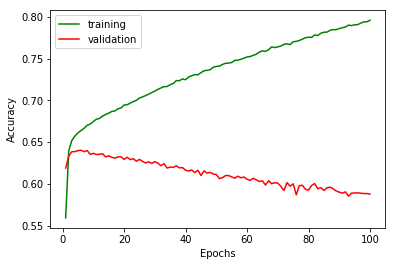

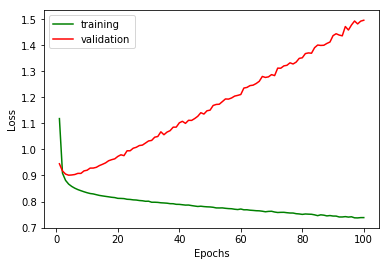

In [68]:
## L1 regularization

import matplotlib.pyplot as plt


real_epochs = len(history.history['acc'])
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#plt.figure()
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['loss'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_loss'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Confusion matrix on validation data

In [69]:
y_prediction = model.predict(x_val)
y_prediction[0]

array([  3.52036892e-07,   8.01074566e-05,   2.40888912e-03,
         3.54952663e-01,   6.42557919e-01], dtype=float32)

In [70]:
test_predicted_class = np.argmax(y_prediction,axis=1)
test_predicted_class[0]
len(test_predicted_class)

40386

In [71]:
#y_train = rating_list
#x_val = x_train[:round(0.3*len(Train))]
#y_val = y_train[:round(0.3*len(Train))]
y_val2 = np.asarray(y_val_list2).astype('float32')
len(y_val)
len(y_val)

40386

Confusion matrix, without normalization


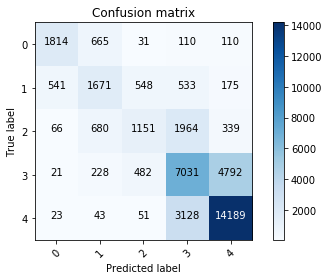

In [72]:

# You can use the code below to plot a confusion matrix


from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(y_val2, test_predicted_class)

## Misclassifications of the model for validation data

In [55]:
# misclassifications
for i in range(100):
    result1 = y_prediction[i]
    result2 = y_val2[i] +1
    if (result1 != result2):
        print(" Predicted rating: ", result1, "\n", "True rating: ", result2 , "\n", "Review: ",X_val_list[i], "\n")

 Predicted rating:  3 
 True rating:  1.0 
 Review:  [['thief', 'hotel', 'spring', 'stayed', 'gallery', 'hotel', 'one', 'holiday', 'week', 'bad', 'surprise', 'stolen', 'brand', 'new', 'camera', 'event', 'today', 'quite', 'month', 'later', 'still', 'news', 'excuse', 'hotel', 'theft', 'police', 'given', 'copy', 'hotel', 'manager', 'filled', 'hotel', 'insurance', 'form', 'may', 'think', 'normal', 'situation', 'stolen', 'good', 'room', 'even', 'worse', 'manager', 'told', 'u', 'evening', 'another', 'room', 'visited', 'ipod', 'florence', 'wonderful', 'city', 'people', 'great', 'plan', 'book', 'gallery', 'art', 'hotel', 'say', 'goodbye', 'good'], ['great', 'position', 'magical', 'city', 'hotel', 'great', 'position', 'nice', 'clean', 'extremely', 'priced', 'room', 'small', 'dark', 'however', 'beauty', 'charm', 'florence', 'fortunately', 'mean', 'dont', 'spend', 'much', 'time', 'room'], ['best', 'staff'], ['charming', 'modern', 'boutique', 'hotel', 'hotel', 'modern', 'hotel', 'located', 'close'

In [71]:
# misclassifications
for i in range(500):
    result1 = y_prediction[i]
    result2 = y_val2[i] +1
    if (result1 != result2):
        print(" Predicted rating: ", result1, "\n", "True rating: ", result2 , "\n", "Review: ",X_val_list2[i], "\n")

 Predicted rating:  3 
 True rating:  1.0 
 Review:  ['thief', 'hotel', 'spring', 'stayed', 'gallery', 'hotel', 'one', 'holiday', 'week', 'bad', 'surprise', 'stolen', 'brand', 'new', 'camera', 'event', 'today', 'quite', 'month', 'later', 'still', 'news', 'excuse', 'hotel', 'theft', 'police', 'given', 'copy', 'hotel', 'manager', 'filled', 'hotel', 'insurance', 'form', 'may', 'think', 'normal', 'situation', 'stolen', 'good', 'room', 'even', 'worse', 'manager', 'told', 'u', 'evening', 'another', 'room', 'visited', 'ipod', 'florence', 'wonderful', 'city', 'people', 'great', 'plan', 'book', 'gallery', 'art', 'hotel', 'say', 'goodbye', 'good'] 

 Predicted rating:  1 
 True rating:  3.0 
 Review:  ['great', 'position', 'magical', 'city', 'hotel', 'great', 'position', 'nice', 'clean', 'extremely', 'priced', 'room', 'small', 'dark', 'however', 'beauty', 'charm', 'florence', 'fortunately', 'mean', 'dont', 'spend', 'much', 'time', 'room'] 

 Predicted rating:  4 
 True rating:  5.0 
 Review:  ['

 True rating:  1.0 
 Review:  ['stay', 'somewhere', 'else', 'really', 'question', 'reviewer', 'motif', 'experience', 'giving', 'hotel', 'excellent', 'review', 'you鈥檙e', 'already', 'locked', 'reservation', 'can鈥檛', 'change', 'resort', 'selection', 'stay', 'away', 'buffet', 'food', 'probably', 'directed', 'eat', 'first', 'night', 'stray', 'cat', 'roaming', 'buffet', 'area', 'didn鈥檛', 'seem', 'bad', 'tasted', 'food', 'steak', 'like', 'beef', 'cold', 'rather', 'reminded', 'youre', 'third', 'world', 'country', 'hop', 'go', 'beach', 'grill', 'located', 'near', 'hotel', 'room', 'number', 'hot', 'grill', 'beef', 'even', 'better', 'grilled', 'lobster', 'might', 'wait', 'long', 'line', 'maybe', 'minute', 'breakfast', 'lunch', 'also', 'served', 'beach', 'grill', 'two', 'waste', 'time', 'buffet', 'staff', 'hotel', 'courteous', 'guy', 'asking', 'wanted', 'go', 'meeting', 'day', 'three', 'got', 'picture', 'interested', 'attending', 'meeting', 'possibly', 'booking', 'room', 'resort', 'could', 'possib

In [73]:
content_list

['What A P.O.S.',
 "Nice renovation We stayed at the hotel for 6 nights. The location is a bit touristy. The hotel is nicely renovated. Room is big and bright. But the bathroom is still tight. Only thing is the heater is a bit noisy. and they should place a minibar in the room. Hotel offers valet parking but it's very expensive. You can park your car in the garage accross from the hotel or search for a street parking maybe one or two blocks away from the hotel. I love the new Sheraton bed, they are really comfortable.",
 'Ottimo Hotel vicino a Union Square',
 'Be wary! Stayed for four nights on a business trip and was impressed with the size of the room etc. However, I found there was some rather foul stains (females staying along do not make marks like that) on the duvet cover, which obviously had not been washed - told the hotel staff and it was rectified but I received no apology etc. Really not acceptable in a hotel aiming to be top tier and fairly disgusting. So check your bedshee